# 다항 모델

## Polynomial Model

#### 다항 모델의 사용

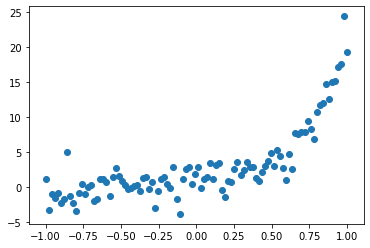

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
최종 w 값: [0.6787607 1.7136904 3.76791   4.7790384 5.014189  5.0703545]


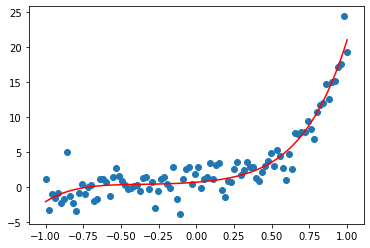

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

learning_rate = 0.01
training_epochs = 40

# 입력 데이터 생성
trX = np.linspace(-1, 1, 100)

# 출력 데이터 생성
num_coeffs = 6
trY_coeffs = [1, 2, 3, 4, 5, 6]
trY = 0
for i in range(num_coeffs):
    trY += trY_coeffs[i] * np.power(trX, i)

# 노이즈 생성
trY += np.random.randn(*trX.shape) * 1.5

# 원 데이터의 산포도 그리기
plt.scatter(trX, trY)
plt.show()

# 입력/출력 쌍의 값을 저장할 노드 정의
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 다항 모델을 정의
def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    return tf.add_n(terms)

# 파라미터 벡터를 모두 0으로 설정
w = tf.Variable([0.] * num_coeffs, name='parameters')
y_model = model(X, w)

# 비용 함수 정의
cost = (tf.pow(Y - y_model, 2))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(training_epochs):
    for (x, y) in zip(trX, trY):
        sess.run(train_op, feed_dict={X : x, Y : y})

w_val = sess.run(w)
print(f"최종 w 값: {w_val}")

sess.close()

# 결과 시각화하기
plt.scatter(trX, trY)
trY2 = 0
for i in range(num_coeffs):
    trY2 += w_val[i] * np.power(trX, i)
plt.plot(trX, trY2, 'r')
plt.show()




## 정규화(Regularization)

#### 데이터셋을 테스트셋과 학습셋으로 분리하기

In [4]:
# 인자로 입력 데이터셋, 출력 데이터셋, 분리 비율을 받는다.
def split_dataset(x_dataset, y_dataset, ratio):
    # 리스트의 값들 섞기
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    # 학습 데이터의 개수 
    num_train = int(ratio * x_dataset.size)
    # x_dataset 분리
    x_train = x_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    # y_dataset 분리
    y_train = y_dataset[arr[0:num_train]]
    y_test = y_dataset[arr[num_train:y_dataset.size]]
    
    return x_train, x_test, y_train, y_test 


- 하지만, 위 처럼 함수를 별도로 만들지 않고 scikit-learn에서 제공하는 함수를 사용할 수 있다.

- sklearn.model_selection.train_test_split 함수

#### 정규화 파라미터 평가하기

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

learning_rate = 0.001
training_epochs = 1000
reg_lambda = 0.

# 입력 데이터
x_dataset = np.linspace(-1, 1, 100)

# 출력 데이터
num_coeffs = 9
y_dataset_params = [0.] * num_coeffs
y_dataset_params[2] = 1
y_dataset = 0
for i in range(num_coeffs):
    y_dataset += y_dataset_params[i] * np.power(x_dataset, i)
y_dataset += np.random.randn(*x_dataset.shape) * 0.3

# 위 쪽에서 만든 split_dataset() 함수 사용
x_train, x_test, y_train, y_test = split_dataset(x_dataset, y_dataset, 0.7)

# 입력/출력 플레이스홀더 설정
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 모델 정의
def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)

    return tf.add_n(terms)

# 정규화된 비용 함수 정의
w = tf.Variable([0.] * num_coeffs, name='parameters')
y_model = model(X, w)
cost = tf.div(tf.add(tf.reduce_sum(tf.square(Y - y_model)), 
                                    tf.multiply(reg_lambda, tf.reduce_sum(tf.square(w)))), 
                                    2 * x_train.size)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# 세션 설정
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# 다양한 정규화 파라미터 시도
for reg_lambda in np.linspace(0, 1, 100):
    for epoch in range(training_epochs):
        sess.run(train_op, feed_dict={X : x_test, Y : y_test})
    final_cost = sess.run(cost, feed_dict={X : x_test, Y : y_test})

    # print(f"reg lambda: {reg_lambda}")
    # print(f"final cost: {final_cost}")        

sess.close()